In [ ]:
# NOTE: check the solver, as there may be some mistakes

# Analytical Solution of tau_E and P_loss System

This notebook solves the coupled 2×2 system:
1. **Energy confinement**: `tau_E = W_th / P_loss`
2. **IPB98(y,2) scaling**: `tau_E = H98_y2 × 0.0562 × I_p^0.93 × B0^0.15 × n_la^0.41 × P_loss^(-0.69) × R^1.97 × kappa_ipb^0.78 × A^(-0.58) × afuel^0.19`

Combining these gives: `W_th = C × P_loss^0.31`, where C contains all the other parameters.

Solving: `P_loss = (W_th / C)^(1/0.31)`

In [ ]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

# Setup path to fusdb
def find_repo_root(start: Path) -> Path:
    for path in (start, *start.parents):
        if (path / 'reactors').is_dir() and (path / 'src' / 'fusdb').is_dir():
            return path
    return start

root = find_repo_root(Path.cwd())
src_path = str(root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from fusdb import Reactor

print(f"Repository root: {root}")

Repository root: /home/alessmor/Scrivania/fusdb


## Configuration: Choose Parameter Source

Set `USE_HARDCODED = True` to use hardcoded parameters below, or `False` to load from YAML reactor file.

In [ ]:
    # Extract input parameters (before solve)
    I_p = reactor.variables_dict['I_p'].input_value
    B0 = reactor.variables_dict['B0'].input_value
    R = reactor.variables_dict['R'].input_value
    a = reactor.variables_dict['a'].input_value
    A = R / a  # Calculate from R and a
    afuel = reactor.variables_dict['afuel'].input_value
    H98_y2 = reactor.variables_dict['H98_y2'].input_value
    kappa_95 = reactor.variables_dict['kappa_95'].input_value
    f_GW = reactor.variables_dict['f_GW'].input_value

Using HARDCODED parameters:
  I_p = 17.75 MA
  B0 = 5.86 T
  R = 9.00 m
  a = 2.90 m
  A = 3.1034
  afuel = 2.50 amu
  H98_y2 = 0.980
  kappa_95 = 1.650
  kappa_ipb ≈ 1.716
  f_GW = 1.20
  n_la = 9.76×10^19 m^-3

Estimated W_th from T_avg=12.0 keV:
  V_plasma = 2465.20 m³
  W_th ≈ 1.388 GJ
  (Note: This is a rough estimate. For better accuracy, provide W_th directly)


## Compute W_th

If W_th was provided (hardcoded mode), use it. Otherwise, solve the full reactor system to get W_th.

In [ ]:
    # Extract W_th from full solution
    W_th = float(reactor.variables_dict['W_th'].current_value)
    P_loss_full = reactor.variables_dict['P_loss'].current_value
    tau_E_full = reactor.variables_dict['tau_E'].current_value


Using provided W_th = 1.3876 GJ


## Analytical Solution of the Coupled System

### Step 1: Compute the coefficient C

From the IPB98(y,2) scaling:
$$\tau_E = H_{98} \times 0.0562 \times I_p^{0.93} \times B_0^{0.15} \times n_{la}^{0.41} \times P_{loss}^{-0.69} \times R^{1.97} \times \kappa^{0.78} \times A^{-0.58} \times a_{fuel}^{0.19}$$

Combining with $W_{th} = \tau_E \times P_{loss}$:
$$W_{th} = C \times P_{loss}^{0.31}$$

where:
$$C = H_{98} \times 0.0562 \times I_p^{0.93} \times B_0^{0.15} \times n_{la}^{0.41} \times (10^6)^{0.69} \times R^{1.97} \times \kappa^{0.78} \times A^{-0.58} \times a_{fuel}^{0.19}$$

In [30]:
# Calculate coefficient C (all terms except P_loss)
# Note: P_loss in the formula is in MW, so we include (1e6)^0.69 conversion factor
C = (H98_y2 * 0.0562 * 
     (I_p/1e6)**0.93 * 
     B0**0.15 * 
     (n_la/1e19)**0.41 * 
     (1e6)**0.69 * 
     R**1.97 * 
     kappa_ipb**0.78 * 
     A**(-0.58) * 
     afuel**0.19)

print(f"Coefficient C = {C:.6e}")
print(f"\nThis represents: tau_E × 1 MW = {C:.6e} s")
print(f"Or equivalently: W_th = {C:.6e} × P_loss^0.31")

Coefficient C = 2.610333e+06

This represents: tau_E × 1 MW = 2.610333e+06 s
Or equivalently: W_th = 2.610333e+06 × P_loss^0.31


### Step 2: Solve for P_loss

From $W_{th} = C \times P_{loss}^{0.31}$:
$$P_{loss} = \left(\frac{W_{th}}{C}\right)^{1/0.31} = \left(\frac{W_{th}}{C}\right)^{3.226}$$

In [31]:
# Solve for P_loss
exponent = 1 / 0.31
P_loss_solved = (W_th / C)**exponent

print(f"Analytical solution:")
print(f"  P_loss = (W_th / C)^{exponent:.3f}")
print(f"  P_loss = ({W_th/1e9:.4f} GJ / {C:.6e})^{exponent:.3f}")
print(f"  P_loss = {P_loss_solved/1e6:.2f} MW")

Analytical solution:
  P_loss = (W_th / C)^3.226
  P_loss = (1.3876 GJ / 2.610333e+06)^3.226
  P_loss = 619.68 MW


### Step 3: Calculate tau_E from solved P_loss

In [32]:
# Calculate tau_E from IPB98(y,2) scaling with solved P_loss
tau_E_ipb = (0.0562 * 
             (I_p/1e6)**0.93 * 
             B0**0.15 * 
             (n_la/1e19)**0.41 * 
             (P_loss_solved/1e6)**(-0.69) * 
             R**1.97 * 
             kappa_ipb**0.78 * 
             A**(-0.58) * 
             afuel**0.19)

tau_E_solved = H98_y2 * tau_E_ipb

# Verify with energy balance
tau_E_check = W_th / P_loss_solved

print(f"\nCalculated tau_E:")
print(f"  From IPB98: tau_E = {tau_E_solved:.4f} s")
print(f"  From W_th/P_loss: tau_E = {tau_E_check:.4f} s")
print(f"  Difference: {abs(tau_E_solved - tau_E_check):.2e} s (should be ~0)")


Calculated tau_E:
  From IPB98: tau_E = 2.2392 s
  From W_th/P_loss: tau_E = 2.2392 s
  Difference: 3.11e-15 s (should be ~0)


## Comparison with Full Solver (if available)

In [33]:
if P_loss_full is not None and tau_E_full is not None:
    print("\n" + "="*70)
    print("COMPARISON: Analytical Solution vs Full Solver")
    print("="*70)
    
    print(f"\nP_loss:")
    print(f"  Analytical: {P_loss_solved/1e6:.2f} MW")
    print(f"  Full solver: {P_loss_full/1e6:.2f} MW")
    print(f"  Difference: {(P_loss_solved-P_loss_full)/1e6:.2f} MW ({100*(P_loss_solved-P_loss_full)/P_loss_full:+.1f}%)")
    
    print(f"\ntau_E:")
    print(f"  Analytical: {tau_E_solved:.4f} s")
    print(f"  Full solver: {tau_E_full:.4f} s")
    print(f"  Difference: {(tau_E_solved-tau_E_full):.4f} s ({100*(tau_E_solved-tau_E_full)/tau_E_full:+.1f}%)")
    
    print(f"\nW_th (input to analytical solution):")
    print(f"  Value: {W_th/1e9:.4f} GJ")
    print(f"  Check: {tau_E_full * P_loss_full / 1e9:.4f} GJ")
else:
    print("\n" + "="*70)
    print("ANALYTICAL SOLUTION (no full solver comparison)")
    print("="*70)
    
    print(f"\nP_loss (analytical): {P_loss_solved/1e6:.2f} MW")
    print(f"tau_E (analytical): {tau_E_solved:.4f} s")
    print(f"W_th (input): {W_th/1e9:.4f} GJ")



ANALYTICAL SOLUTION (no full solver comparison)

P_loss (analytical): 619.68 MW
tau_E (analytical): 2.2392 s
W_th (input): 1.3876 GJ


## Visualization: tau_E vs P_loss

Plot both relations to show where they intersect:

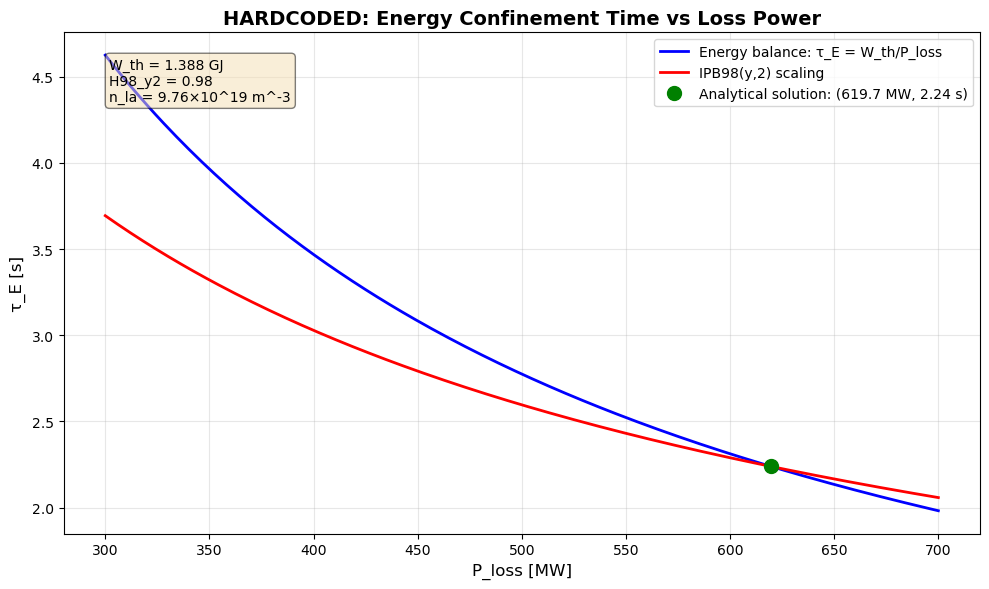


The intersection point is the solution to the coupled system!


In [34]:
# Create range of P_loss values
P_loss_range = np.linspace(300e6, 700e6, 200)

# Calculate tau_E from both relations
tau_E_energy = W_th / P_loss_range  # From energy balance
tau_E_scaling = H98_y2 * 0.0562 * (I_p/1e6)**0.93 * B0**0.15 * (n_la/1e19)**0.41 * (P_loss_range/1e6)**(-0.69) * R**1.97 * kappa_ipb**0.78 * A**(-0.58) * afuel**0.19

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(P_loss_range/1e6, tau_E_energy, 'b-', linewidth=2, label='Energy balance: τ_E = W_th/P_loss')
ax.plot(P_loss_range/1e6, tau_E_scaling, 'r-', linewidth=2, label='IPB98(y,2) scaling')
ax.plot(P_loss_solved/1e6, tau_E_solved, 'go', markersize=10, label=f'Analytical solution: ({P_loss_solved/1e6:.1f} MW, {tau_E_solved:.2f} s)', zorder=5)

if P_loss_full is not None and tau_E_full is not None:
    ax.plot(P_loss_full/1e6, tau_E_full, 'mx', markersize=12, markeredgewidth=2, label=f'Full solver: ({P_loss_full/1e6:.1f} MW, {tau_E_full:.2f} s)', zorder=5)

ax.set_xlabel('P_loss [MW]', fontsize=12)
ax.set_ylabel('τ_E [s]', fontsize=12)
ax.set_title(f'{reactor_name}: Energy Confinement Time vs Loss Power', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Add text box with parameters
textstr = f'W_th = {W_th/1e9:.3f} GJ\nH98_y2 = {H98_y2:.2f}\nn_la = {n_la/1e19:.2f}×10^19 m^-3'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print(f"\nThe intersection point is the solution to the coupled system!")